**Домашнее задание №2** - Латентное пространство в VAE автоенкодере

Прочитайте внимательно статью "Variational Autoencoders are Beautiful":

https://www.compthree.com/blog/autoencoder/

В данном задании необходимо:

1) реализовать VAE автоенкодер с архитектурой как на рисунке:
<img src='mnist_vae.png' width=500>

2) Обучить его на обучающей выборке из базы данных MNIST и после этого, воспользоваться энкодером, чтобы преобразовать картинки из тестовой выборки в латентное пространство и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_cloud.png' width=500>

3) Наконец, построить в латентном пространстве на квадрате [-2, 2]x[-2, 2] сетку из 15x15 значений и построить с помощью декодера картинки цифр для каждого значения из этой сетки и получить рисунок похожий на рисунок ниже:
<img src='vae_mnist_digits.png' width=500>

Для реализации VAE автоенкодера воспользуйтесь кодом ниже:

In [15]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Hyper-parameters
image_size = 784
h_dim = 500 #400
h1_dim = 250
z_dim = 2 #20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)


# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=500, h1_dim=250, z_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, h1_dim)
        self.fc3 = nn.Linear(h1_dim, z_dim)
        self.fc4 = nn.Linear(h1_dim, z_dim)
        self.fc5 = nn.Linear(z_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, h_dim)
        self.fc7 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h), self.fc4(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        return F.sigmoid(self.fc7(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

Epoch[1/15], Step [10/469], Reconst Loss: 35990.5664, KL Div: 807.4413
Epoch[1/15], Step [20/469], Reconst Loss: 28353.2109, KL Div: 29.3523
Epoch[1/15], Step [30/469], Reconst Loss: 25925.8047, KL Div: 10.0308
Epoch[1/15], Step [40/469], Reconst Loss: 25890.8984, KL Div: 19.5505
Epoch[1/15], Step [50/469], Reconst Loss: 26826.6133, KL Div: 59.3480
Epoch[1/15], Step [60/469], Reconst Loss: 26503.0898, KL Div: 164.0872
Epoch[1/15], Step [70/469], Reconst Loss: 24582.9961, KL Div: 259.1865
Epoch[1/15], Step [80/469], Reconst Loss: 24157.0527, KL Div: 385.5876
Epoch[1/15], Step [90/469], Reconst Loss: 24333.9414, KL Div: 276.4270
Epoch[1/15], Step [100/469], Reconst Loss: 24188.7656, KL Div: 347.6494
Epoch[1/15], Step [110/469], Reconst Loss: 24936.3789, KL Div: 337.4870
Epoch[1/15], Step [120/469], Reconst Loss: 23631.2793, KL Div: 387.9303
Epoch[1/15], Step [130/469], Reconst Loss: 22694.2383, KL Div: 447.7282
Epoch[1/15], Step [140/469], Reconst Loss: 22609.1875, KL Div: 524.9011
Epoch

Epoch[3/15], Step [240/469], Reconst Loss: 19386.3203, KL Div: 690.0347
Epoch[3/15], Step [250/469], Reconst Loss: 20037.3086, KL Div: 690.9202
Epoch[3/15], Step [260/469], Reconst Loss: 18838.7578, KL Div: 746.2648
Epoch[3/15], Step [270/469], Reconst Loss: 19106.8789, KL Div: 734.6990
Epoch[3/15], Step [280/469], Reconst Loss: 19005.9512, KL Div: 717.1120
Epoch[3/15], Step [290/469], Reconst Loss: 18994.1309, KL Div: 740.1663
Epoch[3/15], Step [300/469], Reconst Loss: 17984.9609, KL Div: 809.9724
Epoch[3/15], Step [310/469], Reconst Loss: 18323.9941, KL Div: 763.4445
Epoch[3/15], Step [320/469], Reconst Loss: 18834.5586, KL Div: 761.5577
Epoch[3/15], Step [330/469], Reconst Loss: 18782.4805, KL Div: 746.3710
Epoch[3/15], Step [340/469], Reconst Loss: 19469.5273, KL Div: 740.5522
Epoch[3/15], Step [350/469], Reconst Loss: 19934.3203, KL Div: 684.5312
Epoch[3/15], Step [360/469], Reconst Loss: 18758.2227, KL Div: 731.3515
Epoch[3/15], Step [370/469], Reconst Loss: 18371.8516, KL Div: 7

Epoch[6/15], Step [10/469], Reconst Loss: 16919.6680, KL Div: 768.4587
Epoch[6/15], Step [20/469], Reconst Loss: 17511.1445, KL Div: 774.0945
Epoch[6/15], Step [30/469], Reconst Loss: 17691.7969, KL Div: 804.5656
Epoch[6/15], Step [40/469], Reconst Loss: 18616.8203, KL Div: 758.8049
Epoch[6/15], Step [50/469], Reconst Loss: 18043.1445, KL Div: 775.6348
Epoch[6/15], Step [60/469], Reconst Loss: 18348.8418, KL Div: 783.2887
Epoch[6/15], Step [70/469], Reconst Loss: 17694.7773, KL Div: 797.1124
Epoch[6/15], Step [80/469], Reconst Loss: 18045.6016, KL Div: 785.1079
Epoch[6/15], Step [90/469], Reconst Loss: 17468.4805, KL Div: 803.7615
Epoch[6/15], Step [100/469], Reconst Loss: 17569.7539, KL Div: 781.6093
Epoch[6/15], Step [110/469], Reconst Loss: 17521.6406, KL Div: 829.5277
Epoch[6/15], Step [120/469], Reconst Loss: 18350.8398, KL Div: 788.9936
Epoch[6/15], Step [130/469], Reconst Loss: 17943.9453, KL Div: 774.4497
Epoch[6/15], Step [140/469], Reconst Loss: 18087.2031, KL Div: 795.8691
E

Epoch[8/15], Step [240/469], Reconst Loss: 18625.6602, KL Div: 803.8907
Epoch[8/15], Step [250/469], Reconst Loss: 18153.5742, KL Div: 805.3330
Epoch[8/15], Step [260/469], Reconst Loss: 17154.9004, KL Div: 814.0380
Epoch[8/15], Step [270/469], Reconst Loss: 17711.3633, KL Div: 803.8727
Epoch[8/15], Step [280/469], Reconst Loss: 17103.6016, KL Div: 813.5701
Epoch[8/15], Step [290/469], Reconst Loss: 18674.4805, KL Div: 805.7941
Epoch[8/15], Step [300/469], Reconst Loss: 16913.8164, KL Div: 795.4485
Epoch[8/15], Step [310/469], Reconst Loss: 17571.2812, KL Div: 783.6073
Epoch[8/15], Step [320/469], Reconst Loss: 17279.1992, KL Div: 813.3927
Epoch[8/15], Step [330/469], Reconst Loss: 17420.2344, KL Div: 797.6252
Epoch[8/15], Step [340/469], Reconst Loss: 18393.2520, KL Div: 812.7332
Epoch[8/15], Step [350/469], Reconst Loss: 17832.5684, KL Div: 803.1428
Epoch[8/15], Step [360/469], Reconst Loss: 17107.6094, KL Div: 818.8860
Epoch[8/15], Step [370/469], Reconst Loss: 17525.8477, KL Div: 8

Epoch[10/15], Step [460/469], Reconst Loss: 18261.5000, KL Div: 828.2067
Epoch[11/15], Step [10/469], Reconst Loss: 17189.6914, KL Div: 833.7706
Epoch[11/15], Step [20/469], Reconst Loss: 16879.6953, KL Div: 855.9041
Epoch[11/15], Step [30/469], Reconst Loss: 16795.0645, KL Div: 859.5268
Epoch[11/15], Step [40/469], Reconst Loss: 16866.7637, KL Div: 884.9099
Epoch[11/15], Step [50/469], Reconst Loss: 17514.1172, KL Div: 799.8047
Epoch[11/15], Step [60/469], Reconst Loss: 17181.0840, KL Div: 848.5071
Epoch[11/15], Step [70/469], Reconst Loss: 19209.1055, KL Div: 856.2841
Epoch[11/15], Step [80/469], Reconst Loss: 17527.9336, KL Div: 794.5432
Epoch[11/15], Step [90/469], Reconst Loss: 17370.1562, KL Div: 841.8672
Epoch[11/15], Step [100/469], Reconst Loss: 17971.9844, KL Div: 836.1199
Epoch[11/15], Step [110/469], Reconst Loss: 17662.0254, KL Div: 849.8242
Epoch[11/15], Step [120/469], Reconst Loss: 17171.1934, KL Div: 849.0897
Epoch[11/15], Step [130/469], Reconst Loss: 17936.7617, KL D

Epoch[13/15], Step [210/469], Reconst Loss: 18118.1250, KL Div: 855.3790
Epoch[13/15], Step [220/469], Reconst Loss: 17726.8516, KL Div: 837.6533
Epoch[13/15], Step [230/469], Reconst Loss: 16854.5977, KL Div: 828.0052
Epoch[13/15], Step [240/469], Reconst Loss: 17360.1992, KL Div: 835.9739
Epoch[13/15], Step [250/469], Reconst Loss: 17797.2344, KL Div: 813.8488
Epoch[13/15], Step [260/469], Reconst Loss: 17172.6836, KL Div: 843.5099
Epoch[13/15], Step [270/469], Reconst Loss: 17575.4219, KL Div: 845.9989
Epoch[13/15], Step [280/469], Reconst Loss: 18099.1055, KL Div: 820.4862
Epoch[13/15], Step [290/469], Reconst Loss: 17131.9121, KL Div: 854.6347
Epoch[13/15], Step [300/469], Reconst Loss: 16896.1758, KL Div: 840.8130
Epoch[13/15], Step [310/469], Reconst Loss: 17346.1016, KL Div: 834.2603
Epoch[13/15], Step [320/469], Reconst Loss: 16732.9180, KL Div: 851.1576
Epoch[13/15], Step [330/469], Reconst Loss: 18495.5469, KL Div: 841.4865
Epoch[13/15], Step [340/469], Reconst Loss: 16721.5

Epoch[15/15], Step [420/469], Reconst Loss: 17181.4648, KL Div: 851.0456
Epoch[15/15], Step [430/469], Reconst Loss: 17544.0176, KL Div: 826.3618
Epoch[15/15], Step [440/469], Reconst Loss: 17412.7344, KL Div: 882.4219
Epoch[15/15], Step [450/469], Reconst Loss: 17684.4453, KL Div: 883.0036
Epoch[15/15], Step [460/469], Reconst Loss: 17267.6484, KL Div: 823.9583


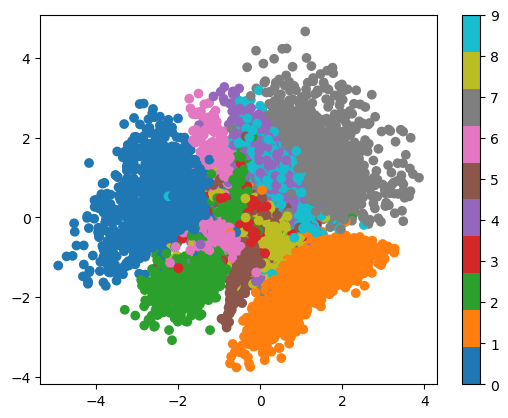

In [20]:
import matplotlib.pyplot as plt

loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

for i, (x, y) in enumerate(loader):
        x=x.view(-1, image_size)
        t = model.reparameterize(model.encode(x.to(device))[0], model.encode(x.to(device))[1])
        t = t.to(device).detach().numpy()
        plt.scatter(t[:, 0], t[:, 1], c=y, cmap='tab10')
        if i > batch_size:
            plt.colorbar()
            break

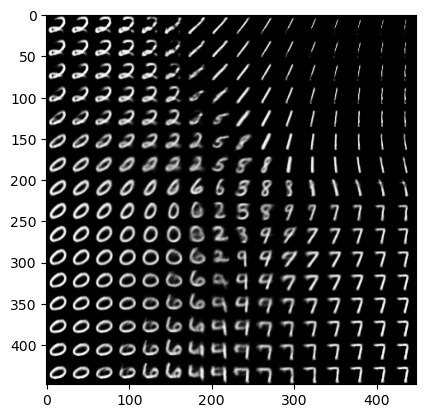

In [21]:
values = np.arange(-4, 4, .5)
xx, yy = np.meshgrid(values, values)
point = np.zeros((1, 2))
container = np.zeros((28 * len(values), 28 * len(values))) #392*392, 392 = 28*14


for row in range(xx.shape[0]):
    for col in range(xx.shape[1]):
        point[0, :] = [xx[row, col], yy[row, col]]
        model.decode(torch.from_numpy(point[0, :]).float())
        new_image = model.decode(torch.from_numpy(point[0, :]).float())
        new_image = new_image.detach().numpy()
        container[row * 28: (row + 1) * 28, col * 28: (col + 1) * 28] = np.reshape(new_image, (28, 28))
plt.imshow(container, cmap='gray')